# Réalisation d'une classification automatisée d'objets

## 2. Modèle supervisé

Afin d'afiner les résultats obtenus avec le modèle non supervisé en partie 1, nous réalisons à présent l'étude du modèle supervisé.

In [3]:
# Bibliothèque standard
import os
from os import listdir
from glob import glob
import re
import time
from time import strftime
from datetime import datetime
import requests

# Bibliothèques tierces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2
from PIL import Image, ImageOps
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn import cluster, metrics, preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import StandardScaler


C:\anaconda\envs\6_market\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import tensorflow as tf

# Vérifier la version de TensorFlow
print("TensorFlow version:", tf.__version__)

# Lister les dispositifs physiques disponibles
print("Dispositifs physiques disponibles:")
devices = tf.config.list_physical_devices()
for device in devices:
    print(device)

# Vérifier la disponibilité des GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs disponibles:")
    for gpu in gpus:
        print(gpu)
else:
    print("Aucun GPU disponible.")

TensorFlow version: 2.10.1
Dispositifs physiques disponibles:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
Aucun GPU disponible.


Dans le cadre de l'étude de faisabilité nous utiliserons les fonctions suivantes :

In [3]:
# Fonction de preprocessing image

def preprocess_image(image_path, target_size=(224, 224)):
    # Read the image
    image = cv2.imread(image_path)
    
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} could not be loaded.")
   
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Apply median blur
    image = cv2.medianBlur(image, 5)

    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    image = cv2.equalizeHist(image)
   
    return image

# Fonction de preprocessing texte

def preprocess_text(text):
    
    lemmatizer = WordNetLemmatizer()
    
    # NB : stopword peut contenir des mots interessants, passer une liste peut etre plus judicieux cf. contexte
    stop_words = stopwords.words('english')
    
    # Extend the stop words set with additional words
    additional_stop_words = [
        'com', 'flipkart', 'product', 'cash', 'shipping',
        'delivery', 'free', 'buy', 'day', 'replacement', 'guarantee',
        'product','online']
    
    stop_words += additional_stop_words
    
    stop_words = set(stop_words)
       
    text = text.lower()
    
    words = word_tokenize(text)
    
  #  words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha()]
    
    words_clean =[]
    for word in words :
        if word not in stop_words :
            if word == 'product' : print(word)
            words_clean+=[word]
    words = words_clean
    
    if 'product' in words: print('erreur')
    
    preprocessed_text = ' '.join(words)
            
    return preprocessed_text


# Fonction de visualisation des n mots les plus représentés

def top_words(corpus, n=10):
    # Initialiser TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Transformer le corpus en matrice de termes TF-IDF
    X = vectorizer.fit_transform(corpus)

    # Récupérer les noms des termes
    terms = vectorizer.get_feature_names_out()

    # Calculer les scores TF-IDF moyens pour chaque terme
    tfidf_scores = X.mean(axis=0).A1

    # Créer un dictionnaire des termes et de leurs scores TF-IDF
    word_tfidf = {terms[i]: tfidf_scores[i] for i in range(len(terms))}

    # Trier les termes par scores TF-IDF
    sorted_word_tfidf = sorted(word_tfidf.items(), key=lambda item: item[1], reverse=True)

    for word, score in sorted_word_tfidf[:n]:
        print(f"{word}: {score}")

    # Créer un dictionnaire pour WordCloud
    wordcloud_data = {word: score for word, score in sorted_word_tfidf[:n]}

    # Générer le WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

    # Afficher le WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

# Fonction de visualisation des résultats graphique et ARI
def visu_TSNE(X, label_true) :

    print("Dimensions dataset avant réduction PCA : ", X.shape)
    pca = PCA(n_components=0.99)
    feat_pca= pca.fit_transform(X)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

    tsne = TSNE(n_components=2, perplexity=30, 
                         n_iter=2000, random_state=42)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["class"] = label_true
    print(df_tsne.shape)
   
    sns.scatterplot(data = df_tsne, x='tsne1', y='tsne2', hue = 'class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    cls = cluster.KMeans(n_clusters=7, random_state=42)
    label_pred = cls.fit_predict(X_tsne)

    ari_score = adjusted_rand_score(label_true, label_pred)
    
    print(f"ARI : {ari_score}")

    
    
# Fonction pour définir les "bags of visual words"    
def build_histogram(kmeans, des, image_num):
    des = des.astype(np.float32)
    if not des.dtype == np.float32:
        raise ValueError(f"Descriptor data type is {des.dtype}, expected np.float32")
    # Ensure kmeans cluster centers are also of type np.float32
    if not kmeans.cluster_centers_.dtype == np.float32:
        kmeans.cluster_centers_ = kmeans.cluster_centers_.astype(np.float32)
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist





# Bag-of-Words (Count and TF-IDF)
def extract_bow_tfidf_features(text_column):
    print('Traitement bow en cours ...')
    print(datetime.now().strftime("%H:%M"))
    
    print(len(text_column[0]))
    print(text_column[0])

    text_column = [preprocess_text(x) for x in text_column ]

    print(len(text_column[0]))
    print(text_column[0])
    
    count_vectorizer = CountVectorizer()
    tfidf_vectorizer = TfidfVectorizer()
    
    bow_features = count_vectorizer.fit_transform(text_column).toarray()
    tfidf_features = tfidf_vectorizer.fit_transform(text_column).toarray()
    
    return bow_features, tfidf_features

# Word2Vec
def extract_word2vec_features(text_column):
    print('Traitement Word2Vec en cours ...')
    print(datetime.now().strftime("%H:%M"))
   
    
    # Tokenisation du texte
    tokenized_text = [word_tokenize(doc.lower()) for doc in text_column]
    
    # Impression de la taille de tokenized_text (c'est une liste, pas un ndarray, donc pas de .shape)
    print(f"Nombre de documents tokenisés : {len(tokenized_text)}")
    
    # Entraînement du modèle Word2Vec
    model = Word2Vec(sentences=tokenized_text, vector_size=500, window=5, min_count=1, workers=4)
    
    # Création des caractéristiques Word2Vec
    word2vec_features = []
    for words in tokenized_text:
        document_vector = []
        for word in words:
            if word in model.wv:
                document_vector.append(model.wv[word])
        if document_vector:
            mean_vector = np.mean(document_vector, axis=0)
        else:
            mean_vector = np.zeros(500)  # If no words are in the model, use zero vector
        word2vec_features.append(mean_vector)

    scaler = StandardScaler()

    word2vec_features = scaler.fit_transform(np.array(word2vec_features))
        
        
    return word2vec_features
    

# Bert
def extract_bert_features(text_column, batch_size=20):
    print('Traitement BERT en cours ...')
    print(datetime.now().strftime("%H:%M"))
    
    # Initialize tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    
    bert_features = []

    # Process in batches
    for i in range(0, len(text_column), batch_size):
        print(i,i + batch_size)
        batch_texts = text_column[i:i + batch_size]
        inputs = tokenizer(list(batch_texts), return_tensors='pt', padding=True, truncation=True, max_length=512)
        
        # Get BERT outputs
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Compute mean of the last hidden state
        batch_features = outputs.last_hidden_state.mean(dim=1).numpy()
        
        bert_features.append(batch_features)
    
    # Concatenate all features
    bert_features = np.vstack(bert_features)
    
    return bert_features

# Universal Sentence Encoder (USE)
def extract_use_features(text_column):
    print('Traitement USE en cours ...')
    print(datetime.now().strftime("%H:%M"))
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    use_features = embed(text_column.tolist()).numpy()
    return use_features

# Main function to extract features using all approaches
def extract_textual_features(df, text_column_name):
    
    bow_features, tfidf_features = extract_bow_tfidf_features(df[text_column_name])
    word2vec_features = extract_word2vec_features(df[text_column_name])
    use_features = extract_use_features(df[text_column_name])
    bert_features = extract_bert_features(df[text_column_name])

    return {
        'bow_features': bow_features,
        'tfidf_features': tfidf_features,
        'word2vec_features': word2vec_features,
        'use_features': use_features,
        'bert_features': bert_features,
    }

# Fonction pour extraire les features avec SIFT
def sift_feat(images):    
    
    # Detection des keypoints et traductions en descripteur
    
    temps1 = time.time()
    
    sift = cv2.SIFT_create()  # SIFT with 500 keypoints
    sift_keypoints = []
    sift_total_des = np.empty((0, 128))
    
    for name_img in images:
        
        filename = images_path+'/'+name_img

        img = preprocess_image(filename)
        
        if img is None:
            print('=========================')
            print('Error, no image detected')
            print('=========================')
            continue
        
        kp, des = sift.detectAndCompute(img, None)
        
        if des is not None:
            sift_keypoints.append(des)
            sift_total_des = np.vstack((sift_total_des, des))
        else:
            print(f"No descriptors found for image {name_img}.")
    
    # Print some info or perform further processing if needed
    for des, img_path in zip(sift_keypoints[0:10], images[0:10]):
        print(des.shape)
        print(img_path)
    
    duration1 = time.time() - temps1
    print(f"Temps de traitement SIFT descriptor : {duration1:.2f} secondes")

    
    print("Nombre de descripteurs : ", sift_total_des.shape)
    

    
    
    
    # Définition des clusters sur l'ensemble des descripteurs disponibles 
    
    temps1=time.time()

    k = 1000
    print("Création de",k, "clusters de descripteurs ...")

    # Clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sift_total_des)

    duration1=time.time()-temps1
    print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")
    
        

    
    # Définition des bags of visual words sur la base des clusters pour chaque image

    temps1=time.time()

    hist_vectors=[]
    
    for i, image_desc in enumerate(sift_keypoints) :
        if i%100 == 0 : print(i)  
        hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector

    im_features = np.asarray(hist_vectors)

    duration1=time.time()-temps1
    print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


    visu_TSNE(im_features, df_clean["labels"])
    
    return im_features


# Fonction de feature extraction avec VGG16

def vgg16_feat(images):
    temps1 = time.time()
    
    # Load the VGG16 model
    model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    
    features = []
    
    for name_img in images:
        
        filename = images_path+'/'+name_img

        img = cv2.imread(filename)
        
        if img is not None:
            img = cv2.resize(img, (224, 224))
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)  # Use VGG16's preprocessing
            feature = model.predict(img)
            features.append(feature.flatten())
        else:
            features.append(np.zeros((512,)))  # Ensure the correct size for zero padding
    
    duration1 = time.time() - temps1
    print("Processing time for VGG16 features: ", "%15.2f" % duration1, "seconds")
    
    
    features = np.array(features)

    display(features.shape)

    visu_TSNE(features, df_clean["labels"])

    
    return np.array(features)


In [4]:

root_path = r"C:\Users\Cecil\Desktop\Formation\6_market\Flipkart".replace("\\", "/")
images_path = root_path+"/images"

raw_txt = pd.read_csv(root_path+"/flipkart_com-ecommerce_sample_1050.csv")

# image_path = glob(path+'/images/*.jp*')
# data_test_path = glob(path_test+'/test*.jp*')



Nous selectionnons à présent les données utiles pour l'étude, la description, l'image et la catégorie principale de l'objet.

In [8]:
df_clean = raw_txt.copy()
df_clean['labels'] = df_clean['product_category_tree'].map(lambda x : re.sub('[^a-zA-Z]', '', x.lower().split(">>")[0]))
df_clean.rename(columns={'image': 'images'}, inplace=True)
df_clean = df_clean[['labels','images','description']]

# df_clean = df_clean.groupby('labels').apply(lambda x: x.sample(n=100, replace=False)).reset_index(drop=True)


# Afficher les premières lignes du DataFrame échantillonné
df_clean.head()

,labels,images,description
0,homefurnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...
1,babycare,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...
2,babycare,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...
3,homefurnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,homefurnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...


# Apprentissage supervisé sur les images
## Défintion du modèle VGG16 modifié

* x = model0.output : On récupère la sortie du modèle VGG16 après la dernière couche convolutionnelle. Cela représente les caractéristiques extraites de l'image.
* x = GlobalAveragePooling2D()(x) : On applique un pooling global moyen, qui réduit les dimensions spatiales des cartes de caractéristiques. Cela permet de passer d'une carte de caractéristiques 3D à un vecteur 1D, en calculant la moyenne de chaque carte de caractéristiques.
* x = Dense(256, activation='relu')(x) : On ajoute une couche dense (fully connected) avec 256 neurones et une fonction d'activation ReLU (Rectified Linear Unit). Cette couche apprend des combinaisons non linéaires des caractéristiques extraites
* x = Dropout(0.5)(x) : On ajoute une couche de dropout avec un taux de 0.5. Le dropout est une technique de régularisation qui aide à prévenir le surapprentissage (overfitting) en désactivant aléatoirement 50% des neurones lors de chaque itération d'entraînement

* predictions = Dense(n_class, activation='softmax')(x) : On ajoute une dernière couche dense avec n_class neurones (où n_class est le nombre de classes dans notre problème de classification) et une fonction d'activation softmax. La softmax convertit les sorties de la couche en probabilités, chaque neurone représentant la probabilité de l'image appartenant à une des classes

In [24]:
def create_model_fct(n_class) :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_class, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

## Prétraitement des données

Encoding des labels en numérique :

In [25]:
from sklearn.preprocessing import LabelEncoder

df_clean = raw_txt.copy()
df_clean['labels'] = df_clean['product_category_tree'].map(lambda x : re.sub('[^a-zA-Z]', '', x.lower().split(">>")[0]))
df_clean.rename(columns={'image': 'images'}, inplace=True)
df_clean = df_clean[['labels','images']]

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder and transform the categories to numeric values
df_clean['labels'] = encoder.fit_transform(df_clean['labels'])

# To see the mapping
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))

print("Encoded labels:", df_clean['labels'])
print("Label mapping:", label_mapping)


Encoded labels: 0       4
1       0
2       0
3       4
4       4
       ..
1045    0
1046    0
1047    0
1048    0
1049    0
Name: labels, Length: 1050, dtype: int32
Label mapping: {'babycare': 0, 'beautyandpersonalcare': 1, 'computers': 2, 'homedecorfestiveneeds': 3, 'homefurnishing': 4, 'kitchendining': 5, 'watches': 6}


In [26]:

# limitation a 100 image par labels
df_clean = df_clean.groupby('labels').apply(lambda x: x.sample(n=100, replace=False)).reset_index(drop=True)

# mélange des labels 
df_clean = df_clean.sample(frac=1, random_state=42).reset_index(drop=True)
split_index = int(len(df_clean)*0.8)
df_train = df_clean.iloc[:split_index]
df_test = df_clean.iloc[split_index:]

display(df_train)
display(df_test)
def image_prep_fct(data) :
    prepared_images = []
    for image in data['images'] :
        filename = images_path+'/'+image
        img = (load_img(filename,
                        target_size=(224, 224)
                       )
              )
        img = img_to_array(img)
      #   img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np_train = image_prep_fct(df_train)
print(images_np_train.shape)
images_np_test = image_prep_fct(df_test)
print(images_np_test.shape)


C:\Users\Cecil\AppData\Local\Temp\ipykernel_7640\932167561.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('labels').apply(lambda x: x.sample(n=100, replace=False)).reset_index(drop=True)


,labels,images
0,1,5e84d36ad6db970548498829db8b15de.jpg
1,5,aa68675f50a0551b8dadb954017a50a1.jpg
2,3,037b39bef3db7ccd264c577a0edf0c0a.jpg
3,1,4676a8f96abb86c5d1dc5b06c7a11d95.jpg
4,3,3bf09b28e3bf526c2dfebfe591921103.jpg
...,...,...
555,3,9bd8526e99697998cdf7dcbdfa044847.jpg
556,5,dea88a5f46d5fc19236651e6b3e0b3fa.jpg
557,6,d21409978f5e404b53f89e444f7893fe.jpg
558,6,087e83a2406dc98d941b8555356da477.jpg


,labels,images
560,5,63f6ef8f3fda2c306b27cfbf5a005f1e.jpg
561,5,6efd5d260667b94f04edbbd18bb300b9.jpg
562,0,32cf0691248297655e2c1728b12e2262.jpg
563,2,aeb421e416716d5f037d50e8c3b14cd7.jpg
564,1,4d6bf06ef01f80130a1ab28dfdeb7aa3.jpg
...,...,...
695,0,e40e9b4ae48e452dc407d299b467d0c3.jpg
696,1,42a8fef62716772c391fbdd148cc9c16.jpg
697,2,031c98cfde349d99fb6d5983f54c8751.jpg
698,4,ff24511994fc459d04145231c8876d6c.jpg


C:\anaconda\envs\6_market\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(560, 224, 224, 3)
(140, 224, 224, 3)


In [27]:
X = images_np_train
y = to_categorical(df_train['labels'])

X_test = images_np_test
y_test = to_categorical(df_test['labels'])

y_test

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
 

Les données d'entrainement sont réparties entre train et val avec la fonction train test split. Nous utilisons le modèle VGG16 modifié (cf. fonction create_model_fct) pour réaliser la classification.

In [28]:
%%time

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Create the model using GPU
with tf.device('/cpu:0'): 
    model1 = create_model_fct(n_class=7)

# Set up model checkpointing
model1_save_path1 = "./model1_best_weights.keras"
checkpoint = ModelCheckpoint(
    model1_save_path1, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

# Set up early stopping
es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=5
)

# Combine callbacks
callbacks_list = [checkpoint, es]

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/cpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2545 - loss: 9.6898 
Epoch 1: val_loss improved from inf to 1.61178, saving model to ./model1_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.2686 - loss: 9.3711 - val_accuracy: 0.6429 - val_loss: 1.6118
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6372 - loss: 2.0885
Epoch 2: val_loss improved from 1.61178 to 1.38127, saving model to ./model1_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.6403 - loss: 2.0766 - val_accuracy: 0.7214 - val_loss: 1.3813
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6848 - loss: 1.7700
Epoch 3: val_loss improved from 1.38127 to 1.23509, saving model to ./model1_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.6909 - loss: 1.7358 - val_accuracy: 0.7286 - val_loss: 1.2351
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7578 - loss: 1.1454
Epoch 4: val_loss improved from 1.23509 to 1.03

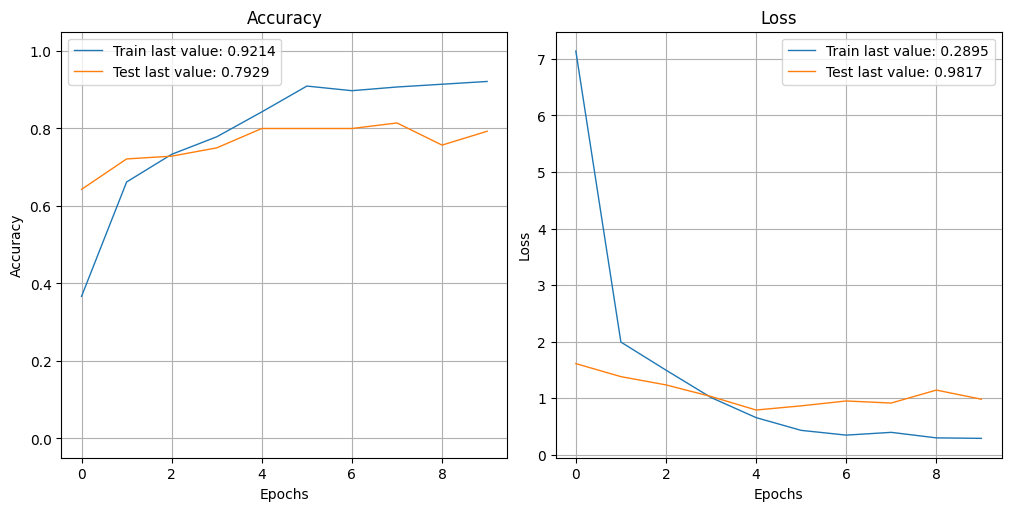

In [31]:
from plot_keras_history import show_history, plot_history

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

## Intégration de la data augmentation

Ici, nous redéfinissons la fonction du modele en ajoutant la data augmentation afin de fournir plus de données en entrée du réseau de neuronnes.

In [41]:
def create_model_fct2(n_class = 7, pc = 0.1) :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(pc),
        RandomZoom(pc),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(n_class, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

En incluant une data augmentation en couche initiale du réseau de neuronnes avec facteur de data augmentation  pc = 1 ou 0.2 :

In [39]:
%%time

# Create the model using GPU
with tf.device('/cpu:0'): 
    model2 = create_model_fct2(n_class=7, pc=1)

# Set up model checkpointing
model2_save_path = "./model2_best_weights.keras"
checkpoint = ModelCheckpoint(
    model2_save_path, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

# Set up early stopping
es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=5
)

# Combine callbacks
callbacks_list = [checkpoint, es]

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/cpu:0'): 
    history2 = model2.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1724 - loss: 2.2526
Epoch 1: val_loss improved from inf to 1.80534, saving model to ./model2_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.1719 - loss: 2.2423 - val_accuracy: 0.3000 - val_loss: 1.8053
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2315 - loss: 1.9208
Epoch 2: val_loss improved from 1.80534 to 1.62644, saving model to ./model2_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.2317 - loss: 1.9194 - val_accuracy: 0.5000 - val_loss: 1.6264
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3373 - loss: 1.7268
Epoch 3: val_loss improved from 1.62644 to 1.48718, saving model to ./model2_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.3380 - loss: 1.7236 - val_accuracy: 0.5643 - val_loss: 1.4872
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4301 - loss: 1.5919
Epoch 4: val_loss improved from 1.48718 to 1.376

7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.6511 - loss: 0.9631 - val_accuracy: 0.7286 - val_loss: 0.9244
Epoch 25/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6230 - loss: 1.0609
Epoch 25: val_loss improved from 0.92439 to 0.91825, saving model to ./model2_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.6252 - loss: 1.0576 - val_accuracy: 0.6929 - val_loss: 0.9183
Epoch 26/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6270 - loss: 1.0374
Epoch 26: val_loss improved from 0.91825 to 0.91571, saving model to ./model2_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.6302 - loss: 1.0313 - val_accuracy: 0.7214 - val_loss: 0.9157
Epoch 27/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6505 - loss: 0.9507
Epoch 27: val_loss improved from 0.91571 to 0.91178, saving model to ./model2_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.6513 - loss: 0.9504 - val_accuracy: 0.6929 - val_loss: 0.9118
Epoch 28/50

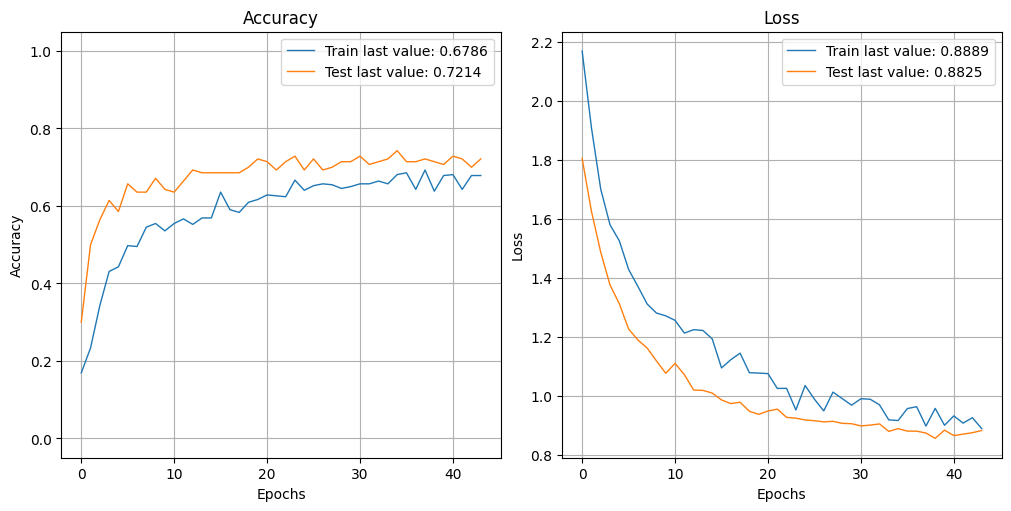

In [40]:
show_history(history2)
plot_history(history2, path="standard2.png")
plt.close()

In [42]:
%%time

# Create the model using GPU
with tf.device('/cpu:0'): 
    model2 = create_model_fct2(n_class=7, pc=0.2)

# Set up model checkpointing
model2_save_path = "./model2_best_weights.keras"
checkpoint = ModelCheckpoint(
    model2_save_path, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

# Set up early stopping
es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=5
)

# Combine callbacks
callbacks_list = [checkpoint, es]

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/cpu:0'): 
    history2 = model2.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1218 - loss: 2.2657
Epoch 1: val_loss improved from inf to 1.69015, saving model to ./model2_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.1250 - loss: 2.2507 - val_accuracy: 0.4857 - val_loss: 1.6901
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2817 - loss: 1.7828
Epoch 2: val_loss improved from 1.69015 to 1.48629, saving model to ./model2_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.2860 - loss: 1.7766 - val_accuracy: 0.6143 - val_loss: 1.4863
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4129 - loss: 1.6202
Epoch 3: val_loss improved from 1.48629 to 1.33069, saving model to ./model2_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.4172 - loss: 1.6122 - val_accuracy: 0.5929 - val_loss: 1.3307
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5305 - loss: 1.3748
Epoch 4: val_loss improved from 1.33069 to 1.191

Epoch 49/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8788 - loss: 0.3717
Epoch 49: val_loss did not improve from 0.72961
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.8790 - loss: 0.3722 - val_accuracy: 0.7643 - val_loss: 0.7437
Epoch 50/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8738 - loss: 0.3852
Epoch 50: val_loss did not improve from 0.72961
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8723 - loss: 0.3890 - val_accuracy: 0.7643 - val_loss: 0.7462
CPU times: total: 4h 11min 26s
Wall time: 26min 29s


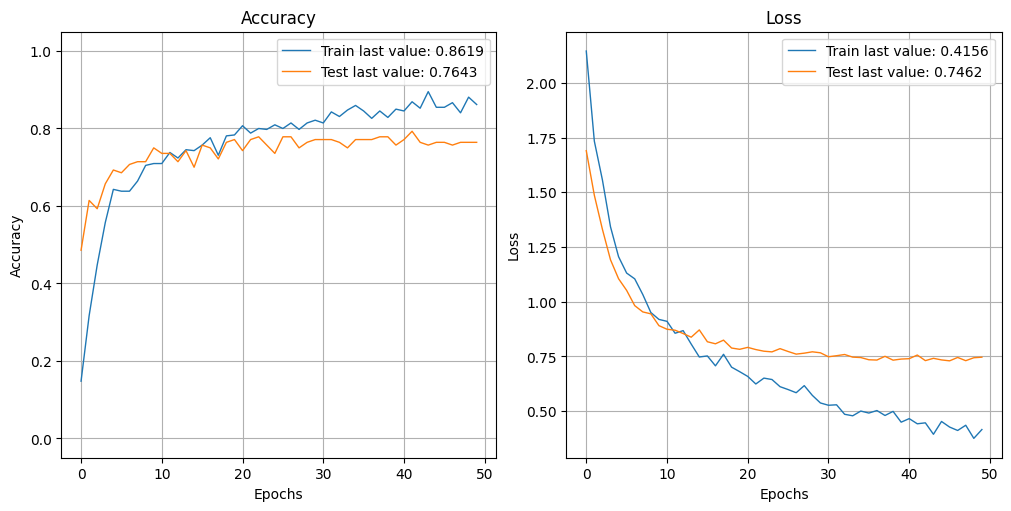

In [43]:
show_history(history2)
plot_history(history2, path="standard2.png")
plt.close()

Trois modèle ont été testés :
* sans data augmentation : accuracy = 0.8
* avec data augmentation (pc=1): accuracy = 0.72
* avec data augmentation (pc=0.2) : accuracy = 0.76. 

La data augmentation ne permet pas d'améliorer les résultats.
